In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")

In [4]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

In [5]:
from utils import create_mask as cm
from simulations.wrapper import simulator
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF
from utils.templates import get_NFW2_template
from sbi import utils
from operator import itemgetter

## Test embedding net

In [6]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [7]:
hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [8]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [9]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [10]:
# Load templates
temp_gce = np.load("../data/fermi_data/template_gce.npy")  # get_NFW2_template(gamma=1.2)
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk = np.load("../data/fermi_data/template_dsk.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

temp_mA_pibrem = hp.ud_grade(np.load('../data/modelA/modelA_brempi0.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/modelA/modelA_ics.npy'), nside_out=128, power=-2)

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask)
roi_mask_norm = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25)

In [114]:
n_samples = 5

In [108]:
def save_files(data_map, aux, theta, sample_name):
    np.save("../data/samples/x_{}.npy".format(sample_name), data_map)
    np.save("../data/samples/x_aux_{}.npy".format(sample_name), aux)
    np.save("../data/samples/theta_{}.npy".format(sample_name), theta)

## Model O

### PS only

In [115]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[1.5, 10.0, 1.1, -10.0, 10.0, 0.1, 0.9, 10.0, 1.1, -10.0, 24.0, 0.1], [1.5, 20.0, 1.99, -9.99, 25.0, 4.99, 1.0, 20.0, 1.99, -9.99, 25.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.000] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

In [116]:
save_files(data_map, aux, thetas, "ModelO_PS_only")

### DM only

In [117]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[0., 10.0, 1.1, -10.0, 10.0, 0.1, 0.9, 10.0, 1.1, -10.0, 24.0, 0.1], [1e-5, 20.0, 1.99, -9.99, 25.0, 4.99, 1.0, 20.0, 1.99, -9.99, 25.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([1.5] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.5] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

In [118]:
save_files(data_map, aux, thetas, "ModelO_DM_only")

### Combination

In [ ]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[0., 10.0, 1.1, -10.0, 10.0, 1.1, 0.001, 10.0, 1.1, -10.0, 24.0, 0.1], [2.5, 20.0, 1.99, -9.99, 25.0, 4.99, 0.001, 20.0, 1.99, -9.99, 25.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.5] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

In [56]:
save_files(data_map, aux, thetas, "ModelO_combination")

## Model A

### PS only

In [50]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 9. / 8., 0.8], [1., 0.22, 0.55, 9.1 / 8., 0.83]]

# gce, dsk
prior_ps = [[1.0, 10.0, 1.1, -10.0, 20.0, 2., 1.0, 10.0, 1.1, -10.0, 24.0, 0.1], [1., 20.0, 1.99, -9.99, 25.0, 4.99, 1.0, 20.0, 1.99, -9.99, 25.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.0] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

In [51]:
save_files(data_map, aux, thetas, "ModelA_PS_only")

### DM only

In [52]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 9. / 8., 0.8], [1., 0.22, 0.55, 9.1 / 8., 0.83]]

# gce, dsk
prior_ps = [[0.0, 10.0, 1.1, -10.0, 20.0, 2., 1.00, 10.0, 1.1, -10.0, 24.0, 0.1], [1e-5, 20.0, 1.99, -9.99, 25.0, 4.99, 1.0, 20.0, 1.99, -9.99, 25.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([1.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.0] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

In [53]:
save_files(data_map, aux, thetas, "ModelA_DM_only")

## Mismodeling

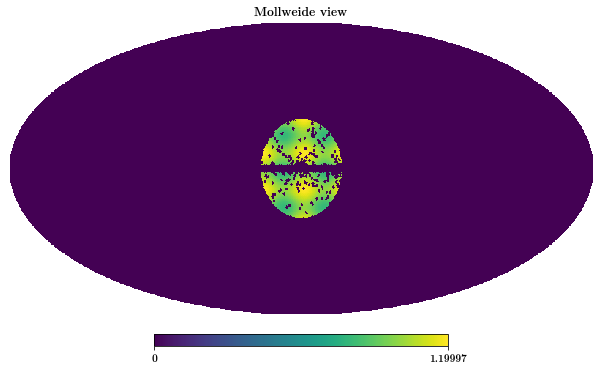

In [41]:
nside = 128
ang = np.asarray(hp.pix2ang(nside,np.arange(12*nside**2),nest=False)).T
mismo_func = 1 + 0.1 * (np.sin(20 * (ang - np.pi / 7.5))[:,0] + np.cos(14 * (ang - np.pi / 7.5))[:,1])

hp.mollview(~roi_mask * mismo_func)

In [42]:
temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, mismo_func * temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

In [43]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[1., 10.0, 1.1, -10.0, 10.0, 0.1, 0.9, 10.0, 1.1, -10.0, 24.0, 0.1], [1., 20.0, 1.99, -9.99, 25.0, 4.99, 1.0, 20.0, 1.99, -9.99, 25.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.000] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/10 [00:00<?, ?it/s]

In [44]:
save_files(data_map, aux, thetas, "ModelO_PS_only_mismo")

In [45]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[0., 10.0, 1.1, -10.0, 10.0, 0.1, 0.9, 10.0, 1.1, -10.0, 24.0, 0.1], [1e-5, 20.0, 1.99, -9.99, 25.0, 4.99, 1.0, 20.0, 1.99, -9.99, 25.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([1.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.0] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
save_files(data_map, aux, thetas, "ModelO_DM_only_mismo")